In [26]:
# Nescessary imports

%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # supress tensorflow warnings


# import libraries
import sys
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

# set random seed
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
if 'data_wraper' in sys.modules: del sys.modules['data_wraper']
if 'models' in sys.modules: del sys.modules['models']

In [28]:
if 'kaggle_web_client' in sys.modules:
    !cp /kaggle/input/libraries/data_wraper.py .
    !cp /kaggle/input/libraries/models.py .
    from data_wraper import Dataset
    from models import UNet, Autoencoder
else:
    from models import UNet, Autoencoder
    from data_wraper import Dataset

In [29]:
# mount google drive if using google colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [30]:
if 'google.colab' in sys.modules:
    root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Colab Notebooks')
elif 'kaggle_web_client' in sys.modules:
    root_dir = os.getcwd()
else:
    root_dir = os.getcwd()

if 'google.colab' in sys.modules:
    data_dir = os.path.join(root_dir, '')
elif 'kaggle_web_client' in sys.modules:
    data_dir = os.path.join('/', 'kaggle', 'input', 'calibration-maps')
else:
    data_dir = os.path.join(root_dir, 'data')

In [31]:
paths = {
    'FOVfiting2' : os.path.join(data_dir, 'mapsCeline_FOVfitting_2_pol-60.mat'),
    '3quadrants2' : os.path.join(data_dir, 'mapsCeline_3quadrants_2_pol-60.mat'),
    'FOVfiting3' : os.path.join(data_dir, 'mapsCeline_FOVfitting_3_pol-60.mat'),
    '3quadrants3' : os.path.join(data_dir, 'mapsCeline_3quadrants_3_pol-60.mat'),
    'FOVfiting4' : os.path.join(data_dir, 'mapsCeline_FOVfitting_4_pol-60.mat'),
    '3quadrants4' : os.path.join(data_dir, 'mapsCeline_3quadrants_4_pol-60.mat'),
    'FOVfiting5' : os.path.join(data_dir, 'mapsCeline_FOVfitting_5_pol-60.mat'),
    '3quadrants5' : os.path.join(data_dir, 'mapsCeline_3quadrants_5_pol-60.mat'),
    'FOVfiting6' : os.path.join(data_dir, 'mapsCeline_FOVfitting_6_pol-60.mat'),
    '3quadrants6' : os.path.join(data_dir, 'mapsCeline_3quadrants_6_pol-60.mat'),   
    'FOVfiting9' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9_pol-60.mat'),
    '3quadrants9' : os.path.join(data_dir, 'mapsCeline_3quadrants_9_pol-60.mat'),
    'FOVfiting9a' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9a_polNP.mat'),
    '3quadrants9a' : os.path.join(data_dir, 'mapsCeline_3quadrants_9a_polNP.mat')
}

In [32]:
calibration_maps = [paths['FOVfiting2'], paths['3quadrants2']] #, paths['FOVfiting3'], paths['3quadrants3']]
dataset = Dataset(calibration_maps)

In [33]:
dataset.preprocess_data()
dataset.crop_data(100)

In [34]:
X = np.stack((dataset.map1_list, dataset.map2_list, dataset.map3_list), axis=-1)
y = dataset.combined_list

In [35]:
print(np.min(X), np.max(X))

0.0 1.0


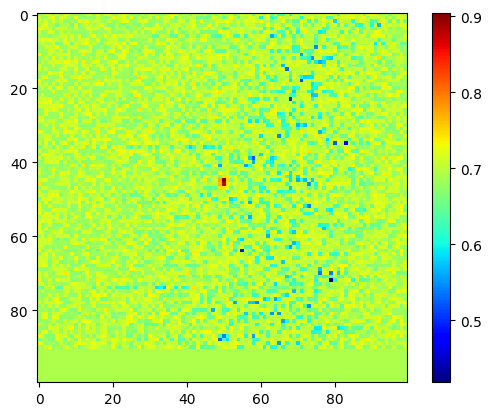

In [36]:
# print one image with the colorbar
ind = random.randint(0, X.shape[0]-1)
plt.imshow(X[ind,:,:,0], cmap='jet')
plt.colorbar()
plt.show()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# measure the mean squared error between some images of the training set
errors = []
for i in range(10):
    errors.append(tf.keras.losses.MSE(X_train[i], X_train[i+1]))
print('Mean squared error between images of the training set:', np.mean(errors))

Mean squared error between images of the training set: 0.003212048909769787


In [39]:
# Model
input_size = (X.shape[1], X.shape[2], 3)
output_size = (y.shape[1], y.shape[2], 1)
optimiser = Adadelta(learning_rate=1.0)
loss = tf.keras.losses.MeanSquaredError()
batch_size = 16
epochs = 20

In [40]:
unet = UNet(input_size, output_size, [32, 64], optimiser, loss)

In [41]:
unet.train(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/20
35/35 [==============================] - 19s 518ms/step - loss: 9.0413e-04 - val_loss: 7.2175e-04
Epoch 2/20
35/35 [==============================] - 18s 503ms/step - loss: 7.1280e-04 - val_loss: 6.8349e-04
Epoch 3/20
35/35 [==============================] - 18s 504ms/step - loss: 6.7816e-04 - val_loss: 6.5525e-04
Epoch 4/20
35/35 [==============================] - 17s 499ms/step - loss: 6.4142e-04 - val_loss: 5.9515e-04
Epoch 5/20
35/35 [==============================] - 17s 497ms/step - loss: 6.4095e-04 - val_loss: 5.7691e-04
Epoch 6/20
35/35 [==============================] - 17s 493ms/step - loss: 5.9844e-04 - val_loss: 5.1601e-04
Epoch 7/20
35/35 [==============================] - 17s 491ms/step - loss: 6.4224e-04 - val_loss: 7.3875e-04
Epoch 8/20
35/35 [==============================] - 17s 489ms/step - loss: 5.9442e-04 - val_loss: 4.3935e-04
Epoch 9/20
35/35 [==============================] - 18s 501ms/step - loss: 5.9090e-04 - val_loss: 4.3752e-04
Epoch 10/20
35/35 [

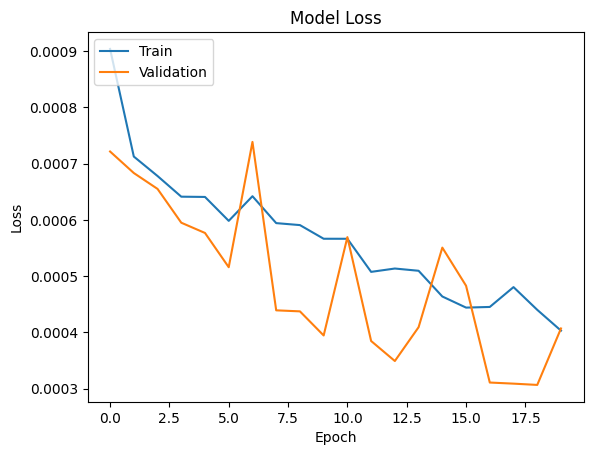

In [44]:
unet.plot_loss()

1/1 [==============================] - 0s 39ms/step


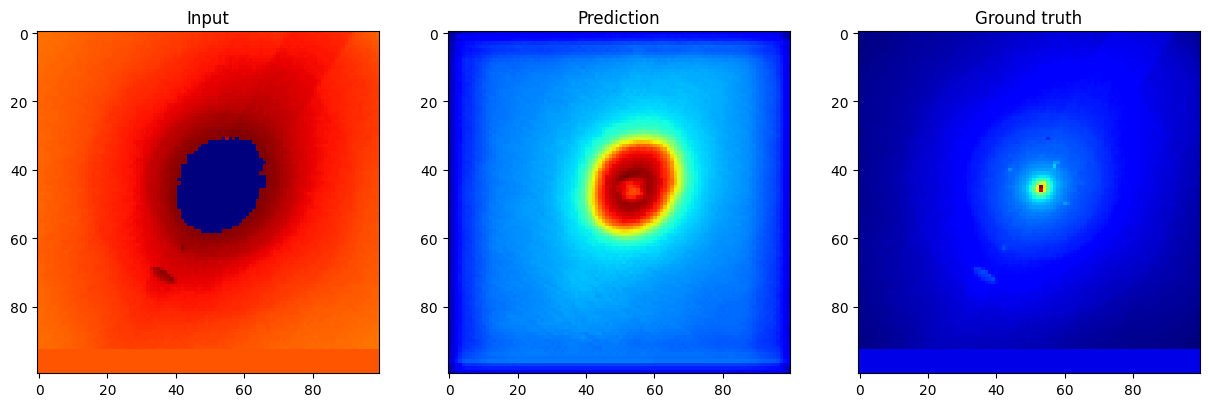

1/1 [==============================] - 0s 41ms/step


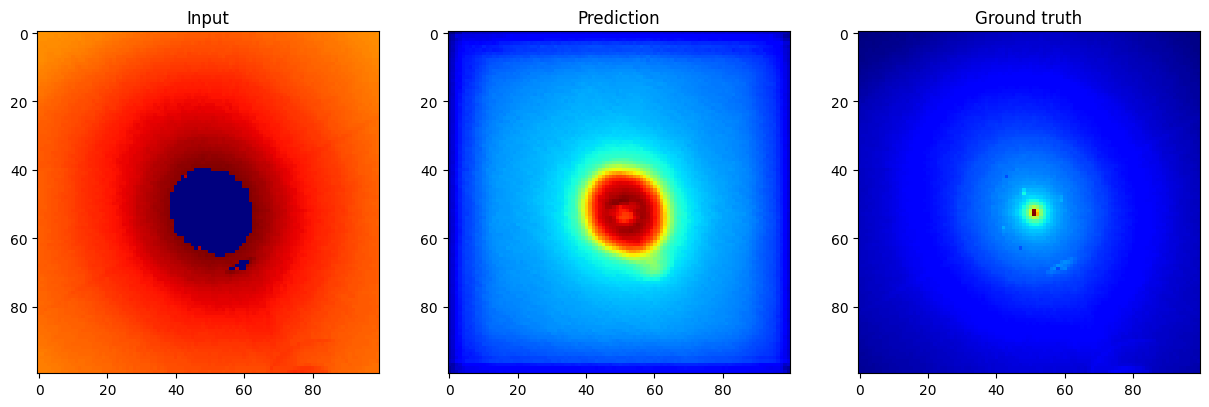

1/1 [==============================] - 0s 34ms/step


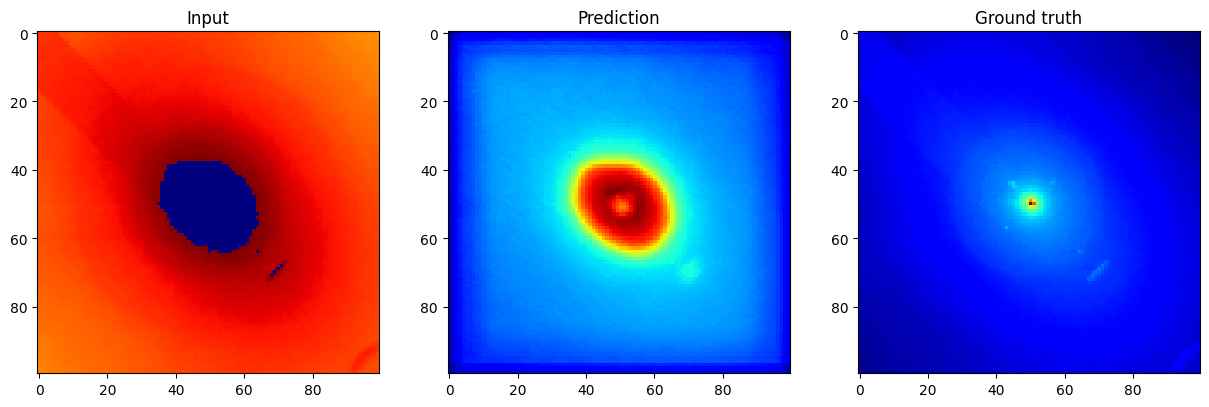

In [45]:
n = 3
for i in range(n):
    ind = random.randint(0, X_test.shape[0]-1)
    pred = unet.predict(X_test[ind:ind+1])
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(X_test[ind,:,:,2], cmap='jet')
    axs[0].set_title('Input')
    axs[1].imshow(pred[0,:,:], cmap='jet')
    axs[1].set_title('Prediction')
    axs[2].imshow(y_test[ind,:,:], cmap='jet')
    axs[2].set_title('Ground truth')
    plt.show()